# Toy Monte Carlo

## Génération de nombres aléatoires selon une distribution donnée

Nous allons commencer par voir une première méthode pour générer des nombres aléatoires suivant une distribution donnée.
La génération de nombres aléatoires selon une distribution uniforme est relativement simple. Pour cela, **nous allons répartir des points de manière uniforme sur un plan.**

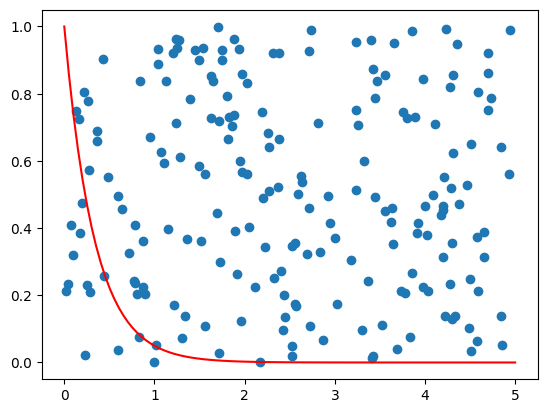

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

def f(x, A=1, c=3):
    return A * np.exp(-c*x)

X = []
Y = []

for _ in range(0,200):
    x = random.uniform(0,5)
    y = random.uniform(0,1)
    X.append(x)
    Y.append(y)

plt.scatter(X,Y, label='Points générés')
plt.plot(np.linspace(0,5,100), f(np.linspace(0,5,100)), 'r', label='Fonction f')
plt.show()




Cependant, vous pouvez le voir, nous constatons qu'ils ne suivent pas encore la distribution de la fonction $f$. Puisque $f$ représente une densité de probabilité, nous allons uniquement conserver les points situés sous sa courbe.

Cela signifie que nous obtiendrons une concentration plus élevée de valeurs de $x$ là où $f(x)$ est grand et une plus faible concentration là où $f(x)$ est petit. (*On peut également voir ça en se disant que le nombre de points sous la courbe par rapport au nombre total de points générés est proportionnel à l'aire sous la courbe par rapport à l'aire totale du rectangle du graphe.*)

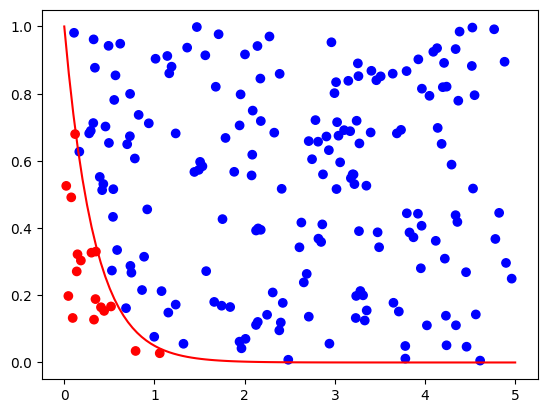

In [2]:
colors = []
X = []
Y = []
for _ in range(0,200):
    x = random.uniform(0,5)
    y = random.uniform(0,1)
    X.append(x)
    Y.append(y)
    if y < f(x):
        colors.append('r')
    else:
        colors.append('b')

plt.scatter(X,Y, c=colors, label='Points générés')
plt.plot(np.linspace(0,5,100), f(np.linspace(0,5,100)), 'r', label='Fonction f')
plt.show()


### Limitation de cette méthode

Un inconvénient de cette approche est son efficacité réduite, car nous ne conservons qu'une partie des points générés (*seulement 6% dans ce cas*). Une amélioration possible consiste à ne générer que des points d'ordonnée $y$ inférieure au maximum de $f(x)$ sur l'intervalle $[0,5]$.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [4]:
def f(x, A=1, c=3):
    return A * np.exp(-c*x)


## Méthode $F^{-1}$

La méthode $F^{-1}$ permet d'optimiser l'efficacité à 100 %, contrairement à la méthode précédente.
Cette approche repose sur l'inversion de la fonction de répartition, ce qui **garantit que chaque valeur générée respecte exactement la distribution cible, sans perte de points inutiles**.


Cette methode se met en place de la manière suivante:

Soit $ f: [a,b] \to \mathbb{R} $, une densité de probabilité.

- Définir la fonction de répartition $ F $, qui est la primitive de la densité de probabilité $ f $ :

  $$
  F(x) = \int_{a}^{x} f(t) \, dt
  $$

- Trouver son inverse $ F^{-1} $, qui existe nécessairement, car $ F $ est bijective sur $ [a,b] $ et prend ses valeurs dans $ [0,1] $.

- Générer un nombre aléatoire $ y $ suivant une distribution uniforme sur $ [0,1] $, puis trouver $ x $ à l’aide de $ F^{-1} $ :

  $$
  x = F^{-1}(y)
  $$

Ainsi, $ x $ suit la distribution donnée par $ f $.







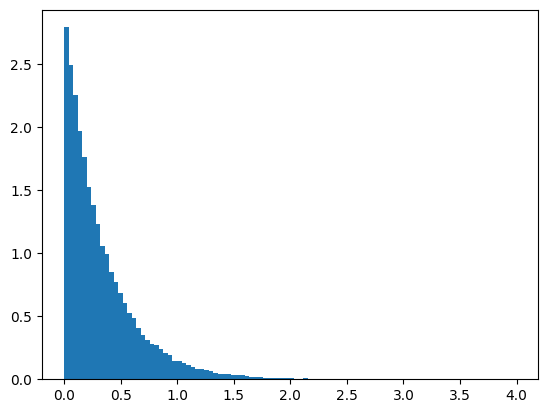

In [5]:
a,b = (0,5)
interval = (a,b)
c = 3

A = c / ( np.exp(-c*a) - np.exp(-c*b) )

def F(x, interval, A=1, c=3):
    a, b = interval
    return -A/c * np.exp(-c*x) + A/c * np.exp(-c*a)

def F_1(y, interval, A=1, c=3):
    a, b = interval
    return -1/c*np.log(-c/A * (y - A/c * np.exp(-c*a)))

X = []

for _ in range(0,100_000):
    y = random.uniform(0,1)
    X.append(F_1(y, interval, A, c))
    
plt.hist(X, bins=100, density=True)
plt.show()

## Genération de donnée pour fit un modèle

(En attente d'une ébauche que je corrigerai...)

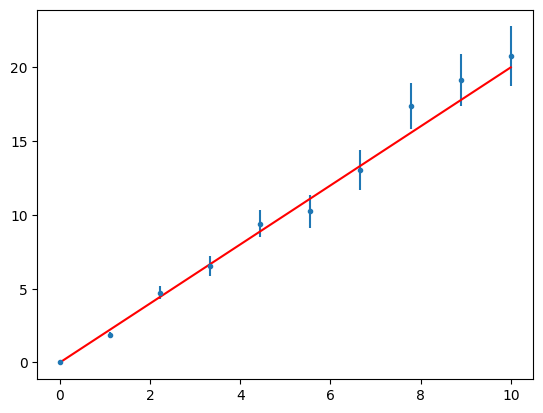

In [6]:
import random
import scipy.optimize as opt

def gen_data(n, model, sigma):
    x = np.linspace(0,10, n)
    y_th = model(x)
    sigmas = sigma(x, y_th)
    y = np.random.normal(0, sigmas) + y_th
    return x, y, sigmas

def model(x, a=2, b=0):
    return a*x+b

def sigma(x, y):
    return 0.1*y

datas = gen_data(10, model, sigma)

x, y, sigmas = datas

y_th = model(x)

plt.errorbar(x, y, yerr=sigmas, fmt='.')
plt.plot(x, y_th, 'r')
plt.show()

## Ajustement

De manière général l'objectif est d'à partir des données générées qui sont expérimentals (car on a ajouté du bruit gaussien) de reconstruire le modèle sous jacent.

### Prèliminaire

#### Notation et considération

On considère un jeu de données $(x_i, y_i)$, $i=1,2,...,n$, avec une incertitude sur $y_i$ que l'on nomme $\sigma_i$. On cherche à ajuster un modèle $y_th = f(x, \vec{\theta})$, où $\vec{\theta}$ est un vecteur de paramètres. On remarquera ici que $\sigma_i$ peut être différent pour chaque point et donc en réalité dépendre de $x_i$ et $y_i$.

### Choix du modèle

Pour n'importe quelle jeu de données, il est possible de trouver une droite qui passe au mieux par ces points. Cependant, est ce que cette droite est la meilleure courbe?

#### Calcule des $z_i$

Une première intuition pour estimer si le modèle coincide avec les données est de faire la différence entre les valeurs expérimentales et les valeurs théoriques. C'est à dire de calculer $y_i - y_th(x_i, \vec{\theta})$. Cependant, cette différence n'inclut pas l'incertitude sur $y_i$. Donc de manière plus générale, on va calculer la quantité suivante: $ z_i = \frac{y_i - y_th(x_i, \vec{\theta})}{\sigma_i}$. On remarque par ailleurs que les z_i sont des variables aléatoires gaussiennes centrées (car si le modèle est parfait on a $y_i - y_th(x_i, \vec{\theta}) = 0$) et réduites (car on a normalisé par $\sigma_i$).

Ces $z_i$ sont des variable aléatoires qui représente a quel point il est possible de trouver d'avoir des données pire que celle observée. Comme ici on cherche à ajuster un modéle sur les données, on va remettre en cause le modèle si les $z_i$ sont trop éloignés de 0. 

#### P-value

Dans le cadre de l'ajustement de modèle, la p-value mesure la probabilité d'obtenir un résultat au moins aussi extrême ou pire que celui observé.

Donc pour une p-value haute, cela signifie qu'il est probable d'obtenir un résultat pire que celui observé. A l'inverse pour une p-value basse, cela signifie qu'il est peu probable d'obtenir un résultat pire que celui observé, le modéle dans ce cas mauvais car il est aisé d'avoir de meilleurs résultats.

En claire, la p-value mesure à quel point les données sont compatibles avec le modèle.

Dans notre cas, la p-value est calculée simplement l'intégrale de la distribution gaussienne centrée réduite de $z_i$ à partir de $z_i$. C'est à dire $p = \int_{z_i}^{+\infty} \frac{1}{\sqrt{2\pi}} e^{-\frac{z^2}{2}} dz$. Et comme la gaussienne est symétrique, on peut aussi calculer $p = 2 \int_{|z_i|}^{+\infty} \frac{1}{\sqrt{2\pi}} e^{-\frac{z^2}{2}} dz$.

Pour n données, on peut calculer la p-value totale en multipliant les p-values de chaque donnée.

En maximisant la p-value total, on maximise la compatibilité de l'ensemble des données avec le modèle.

On remarque que la p-value total est lourde à calculer, car il faut calculer l'intégrale de la gaussienne pour chaque donnée. 

#### Simplification

On sait que que la gaussienne est une densité de probabilité, la p-value est donc proportionnelle à l'image de la gaussienne par $z_i$. On peut donc se contenter de maximiser le produit des images de la gaussienne par $z_i$ (pour maximiser sur l'ensemble des données). C'est à dire de maximiser $\prod_{i=1}^{n} \frac{1}{\sqrt{2\pi}} e^{-\frac{z_i^2}{2}} = \frac{1}{(2\pi)^{n/2}} e^{-\frac{1}{2} \sum_{i=1}^{n} z_i^2}$. 

On remarque que le produit des images de la gaussienne par $z_i$ est proportionnel à l'exponentielle de la somme des carrés des $z_i$. On peut donc se contenter de maximiser l'exponentielle de la somme des carrés des $z_i$.

Et donc on peut se contenter de minimiser (à cause du signe moins) la somme des carrés des $z_i$.

On note cette quantité $\chi^2 (\vec{\theta}) = \sum_{i=1}^{n} z_i^2 = \sum_{i=1}^{n} \left( \frac{y_i - y_th(x_i, \vec{\theta})}{\sigma_i} \right)^2$.

#### Quelques caractéristiques de $\chi^2$

- $\chi^2$ est une quantité positive.
- $\chi^2$ est une mesure de la compatibilité des données avec le modèle.
- $\chi^2$ tend vers 0 pour un nombre infini de données.

#### Crédibilité du modèle via $\chi^2$

Pour un modèle donné, on peut calculer $\chi^2$.
On a plusieurs cas de figure, on considère n le nombre de données et p le nombre de paramètres du modèle.

- si n < p, le modèle est surparamétré, il y a plus de paramètres que de données, le modèle ne peux donc pas être trouvé.

- si n = p, il y a autant de paramètres que de données, le modèle peut être trouvé mais rien ne garantie que le modèle est bon.

- si n > p, il y a plus de données que de paramètres, le modèle peut être trouvé et on peut calculer $\chi^2$. On peut alors comparer $\chi^2$ à n-p:
    - Si $\chi^2$ est proche de n-p, le modèle est bon
    - si $\chi^2$ est très grand, le modèle est mauvais.

/tmp/ipykernel_63492/2140539236.py:3: RuntimeWarning: invalid value encountered in divide
  residuals = (y - y_th) / sigmas  # résidus normalisés


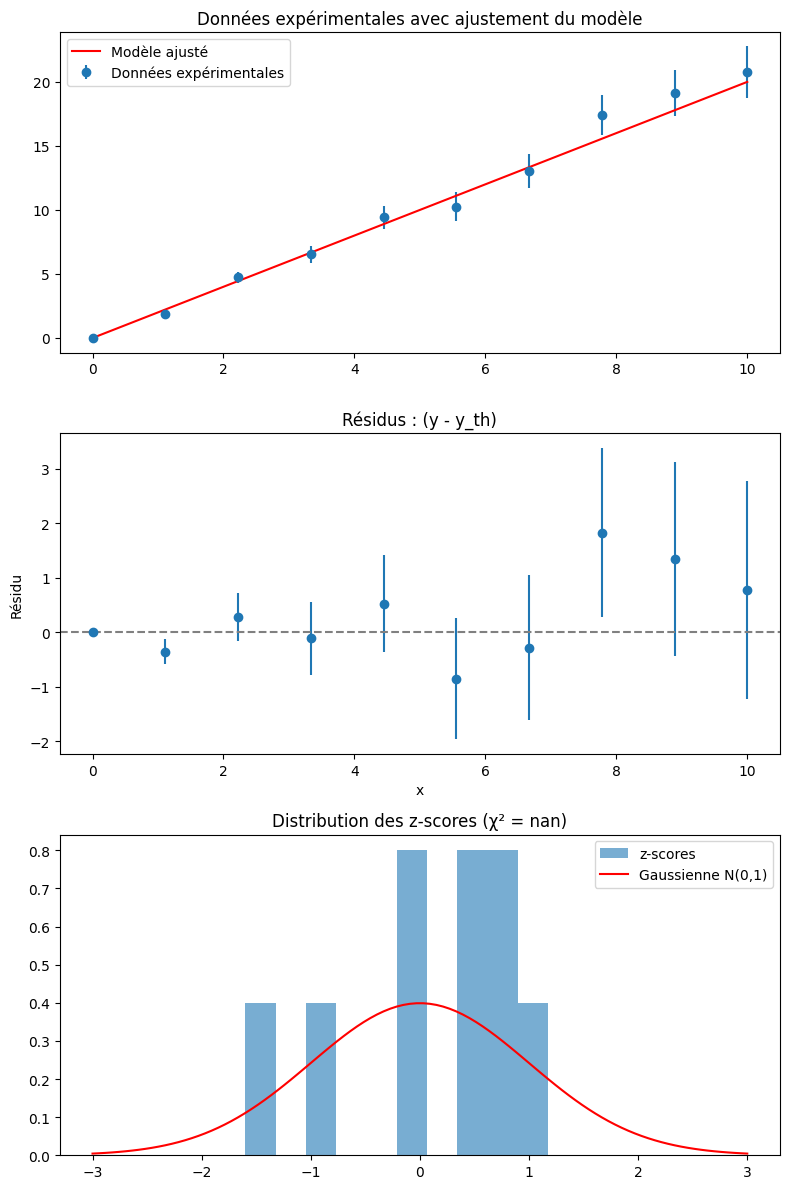

In [ ]:
# Calcul des valeurs théoriques et des résidus
y_th = model(x)  # modèle théorique à partir des données déjà générées
z = (y - y_th) / sigmas  # résidus normalisés

chi2 = np.sum(z**2)  # calcul du chi^2

# Création de trois graphiques pour l'ajustement :
fig, axs = plt.subplots(4, 1, figsize=(8, 12))

# 1. Graphique avec la donnée expérimentale et le modèle ajusté
axs[0].errorbar(x, y, yerr=sigmas, fmt='o', label='Données expérimentales')
axs[0].plot(x, y_th, 'r-', label='Modèle ajusté')
axs[0].set_title("Données expérimentales avec ajustement du modèle")
axs[0].legend()

# 2. Graphique des résidus (y - y_th)
axs[1].errorbar(x, y - y_th, yerr=sigmas, fmt='o')
axs[1].axhline(0, color='gray', linestyle='--')
axs[1].set_title("Résidus : (y - y_th)")
axs[1].set_xlabel("x")
axs[1].set_ylabel("Résidu")

# 3. Histogramme des z-scores et comparaison avec la loi normale standard
axs[2].hist(z, bins=10, density=True, alpha=0.6, label='z-scores')
x_norm = np.linspace(-3, 3, 100)
axs[2].plot(x_norm, 1/np.sqrt(2*np.pi)*np.exp(-0.5*x_norm**2), 'r-', label='Gaussienne N(0,1)')
axs[2].set_title(f"Distribution des z-scores (χ² = {chi2:.2f})")
axs[2].legend()


plt.tight_layout()
plt.show()